Markov State Models for Self-Assembly MD Simulations
------------------

This is EMMAssembly, a jupyter notebook that lets you build *almost* automated Markov State Models from molecular dynamics simulations of your molecular self-assembly/ aggregation simulation. Watch out for the cells that are accompanied by the proclamation "**INPUT NEEDED FROM USER**": those, predictably, need inputs from you. Typically one has to tweak a few variables depending on what kind of system you're dealing with. Usually, clear guildelines are provided on how to set the values of these variables. The other cells can be run blindly, unless you want to tinker.

Let's check which version of Pyemma you have. (This notebook was built by us with Pyemma 2.4.)

In [4]:
import pyemma
pyemma.__version__
import random as rndm

Now importing some libraries and defining a few functions we will be needing...

In [5]:
import matplotlib as mpltlib
import matplotlib.pylab as plt
import numpy as np
#import nglview as nv
%pylab inline
import mdtraj
import numpy as np

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    import pyemma
    pyemma.__version__
    import os
    %pylab inline
    matplotlib.rcParams.update({'font.size': 12})
    import pyemma.coordinates as coor
    import pyemma.msm as msm
    import pyemma.plots as mplt

Populating the interactive namespace from numpy and matplotlib


In [7]:
import pyemma.coordinates as coor

# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order 
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

def save_figure(name):
    # change these if wanted
    do_save = True
    fig_dir = ''
    if do_save:
        savefig(fig_dir + name, bbox_inches='tight')

def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=cm.bwr, cbar=True, cbar_label=None):
    # histogram data
    xmin = np.min(xall)
    xmax = np.max(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.min(yall)
    ymax = np.max(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = gca()
    ax.contourf(z.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = plt.colorbar()
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax

def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=cm.Blues, cbar=True, cbar_label=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, cbar=cbar, cbar_label=cbar_label)

def griddata(x, y, z, binsize=0.01, retbin=True, retloc=True):
    
    # get extrema values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi      = np.arange(xmin, xmax+binsize, binsize)
    yi      = np.arange(ymin, ymax+binsize, binsize)
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid           = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]

            # fill the bin.
            bin = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin.size
            if bin.size != 0:
                binval         = np.median(bin)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid

**INPUT NEEDED FROM USER**: Now we import the topology and trajectory files. Make sure these are located in the same directory as the notebook. Here our topology file is called *protein.gro* and our trajectory files all have the extension .xtc! If this is not true for you (probably isn't!), change the variable "topfile" to what your topology file is called and put the correct extension of your trajectory files instead of '.xtc'.

In [8]:
indir = '.'
topfile =  'protein.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('.xtc'):
        traj_list.append(os.path.join(indir,filename))

**INPUT NEEDED FROM USER**: It is important to note that this notebook assumes your topology/trajectory simply consists of multiple identical instances of the molecule whose self-assembly you're interested in studying (and nothing else!). If this is not true, it would be a good idea to create trajectory files that satisfy this requirement before using this notebook to build an MSM for your system.

Change the value of *atom_mol* to the number of atoms EACH molecule has, according to your topology file.

Change the value of *num_mol* to however many of these molecules your system has.


In [9]:
atom_mol = 41
num_mol = 2

topology = mdtraj.load(topfile).topology


**INPUT NEEDED FROM USER**: You need to choose if you want to work with ALL atoms in your system, just backbone atoms (in case you're studying protein aggregation) or just C-alpha atoms (again, protein only). This is possible by uncommenting the relevant line of code below. Backbone atom selection is uncommented by default. If you want some other, fancier selection, that is possible too, once you learn more about the mdtraj atom selection language. 

For large systems, it might be best to work with a smaller set of atoms (like C-alphas), because dimension reduction calculations will become more expensive the more atoms you select!

In [10]:
back = topology.select("protein and backbone") #select backbone atoms only
#back = topology.select("protein and name CA") #select C alpha atoms only
#back = topology.select("all") #select all atoms

In [11]:
list_select = numpy.split(back, num_mol, axis=0)
back1 = list_select[0]
back_atom = back1.size
dim_permute_sortintra = int((num_mol)*((back_atom)*(back_atom - 1)/2))
dim_permute_sortinter = int(((num_mol*(num_mol-1))/2)*(back_atom)*(back_atom)) #dimension of intra and intermolecular features

Now, we need to define features that are invariant to molecular indices, so that we can feed these to TICA without worrying about degeneracies. We achieve this by sorting or averaging the so-called "permutable distances".

In [12]:
def dist_intermol(traj):
    
    nfram = traj.n_frames #number of frames in input mdtraj traj
    distmat = np.zeros((nfram, (dim_permute_sortinter)), np.float32) #initialize our feature vector
    k_counter = 0 #this one keeps track of the column number of the feature vector that we will update
    
    for i in back1:
        for j in back1:
            if (j == i): 
                pair_list = []
                for m in range(0, num_mol):
                    for n in range(0, num_mol):
                        if (m < n):
                            pair_list.append([m*atom_mol+i, n*atom_mol+i])
                atom_pair = np.array(pair_list)
                dis_inter = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
                dis_inter.sort(axis = 1)
                for m in range(0, int(num_mol*(num_mol-1)/2)):
                    distmat[:,k_counter] = dis_inter[:,m]
                    k_counter = k_counter + 1        
                    
            if (j < i): #ONLY LOWER DIAGONAL ELEMENTS TO AVOID THE SAME DISTANCES
                pair_list = []
                for m in range(0, num_mol):
                    for n in range(0, num_mol):
                        if (m < n):
                            pair_list.append([m*atom_mol+i, n*atom_mol+j])
                            pair_list.append([m*atom_mol+j, n*atom_mol+i])
                atom_pair = np.array(pair_list)
                dis_inter = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
                dis_inter.sort(axis = 1)
                for m in range(0, int(num_mol*(num_mol-1))):
                    distmat[:,k_counter] = dis_inter[:,m]
                    k_counter = k_counter + 1
    
    return distmat
    

In [13]:
def dist_intermol_inv(traj):
    
    nfram = traj.n_frames #number of frames in input mdtraj traj
    distmat = np.zeros((nfram, (dim_permute_sortinter)), np.float32) #initialize our feature vector
    k_counter = 0 #this one keeps track of the column number of the feature vector that we will update
    
    for i in back1:
        for j in back1:
            if (j == i): 
                pair_list = []
                for m in range(0, num_mol):
                    for n in range(0, num_mol):
                        if (m < n):
                            pair_list.append([m*atom_mol+i, n*atom_mol+i])
                atom_pair = np.array(pair_list)
                dis_inter = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
                dis_inter.sort(axis = 1)
                for m in range(0, int(num_mol*(num_mol-1)/2)):
                    distmat[:,k_counter] = dis_inter[:,m]
                    k_counter = k_counter + 1        
                    
            if (j < i): #ONLY LOWER DIAGONAL ELEMENTS TO AVOID THE SAME DISTANCES
                pair_list = []
                for m in range(0, num_mol):
                    for n in range(0, num_mol):
                        if (m < n):
                            pair_list.append([m*atom_mol+i, n*atom_mol+j])
                            pair_list.append([m*atom_mol+j, n*atom_mol+i])
                atom_pair = np.array(pair_list)
                dis_inter = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
                dis_inter.sort(axis = 1)
                for m in range(0, int(num_mol*(num_mol-1))):
                    distmat[:,k_counter] = dis_inter[:,m]
                    k_counter = k_counter + 1
    
    distmat = 1.0/distmat
    return distmat
    

In [14]:
def dist_intramol(traj):
    
    nfram = traj.n_frames #number of frames in input mdtraj traj
    distmat = np.zeros((nfram, (dim_permute_sortintra)), np.float32) #initialize our feature vector
    k_counter = 0 #this one keeps track of the column number of the feature vector that we will update
    
    for i in back1:
        for j in back1:
            if (j < i): #ONLY LOWER DIAGONAL ELEMENTS TO AVOID THE SAME DISTANCES OR SELF-DISTANCES
                pair_list = []
                for m in range(0, num_mol):
                    pair_list.append([m*atom_mol+i, m*atom_mol+j])
                atom_pair = np.array(pair_list)                
                dis_intra = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
                dis_intra.sort(axis = 1)
                for m in range(0, num_mol):
                    distmat[:,k_counter] = dis_intra[:,m]
                    k_counter = k_counter + 1
    
    return distmat

In [15]:
def dist_intramol_inv(traj):
    
    nfram = traj.n_frames #number of frames in input mdtraj traj
    distmat = np.zeros((nfram, (dim_permute_sortintra)), np.float32) #initialize our feature vector
    k_counter = 0 #this one keeps track of the column number of the feature vector that we will update
    
    for i in back1:
        for j in back1:
            if (j < i): #ONLY LOWER DIAGONAL ELEMENTS TO AVOID THE SAME DISTANCES OR SELF-DISTANCES
                pair_list = []
                for m in range(0, num_mol):
                    pair_list.append([m*atom_mol+i, m*atom_mol+j])
                atom_pair = np.array(pair_list)                
                dis_intra = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
                dis_intra.sort(axis = 1)
                for m in range(0, num_mol):
                    distmat[:,k_counter] = dis_intra[:,m]
                    k_counter = k_counter + 1
    
    distmat = 1.0/distmat
    return distmat

**INPUT NEEDED FROM USER**: Choose what features to include below. Uncomment the ones you wish to include, comment out the ones you wish to omit. A brief description of each feature is provided.

If you have a single molecule in your system, do not include intermolecular distances! (makes no sense)

In [16]:
feat = coor.featurizer(topfile)
feat.add_custom_func(dist_intermol, dim_permute_sortinter) # ADD INTERMOLECULAR DISTANCES
#feat.add_custom_func(dist_intermol_inv, dim_permute_sortinter) # ADD INTERMOLECULAR DISTANCE-INVERSES
feat.add_custom_func(dist_intramol, dim_permute_sortintra) # ADD INTRAMOLECULAR DISTANCES
#feat.add_custom_func(dist_intramol_inv, dim_permute_sortintra) # ADD INTRAMOLECULAR DISTANCE-INVERSES

#feat.add_backbone_torsions(cossin=True)
#feat.add_chi1_torsions(cossin=True)
#feat.add_distances(feat.pairs(feat.select_Heavy()), periodic=True)

In [31]:
from pyemma import config
config.show_progress_bars = False

**INPUT NEEDED FROM USER**: Specify the length of each trajectory in *traj_length*.

The next cell prints some useful information.

In [17]:
traj_length = 2000
inp = coor.source(traj_list, feat)
print ('number of trajectories = ',inp.number_of_trajectories())
print ('trajectory length = ',inp.trajectory_length(0))
print ('trajectory time step = ', traj_length/ (inp.trajectory_length(0)-1),'ns')
print ('number of dimension = ',inp.dimension())

number of trajectories =  19
trajectory length =  200001
trajectory time step =  0.01 ns
number of dimension =  496


Now we perform dimension reduction with TICA (Time-lagged independent component analysis). This will be the single most expensive computation we perform in the entire notebook.

**INPUT NEEDED FROM USER**: Specify the TICA lagtime in units of the trajectory time step in the variable *lag*. Since TICA attempts to maximize the autocorrelation of the transformed coordinates at this specified lag time, we should choose this such that it is roughly of the order of the timescale of the processes we want to capture in our reaction coordinates. For our KFFE aggregation simulations, for example, we chose a lagtime of 100 time steps, or 1 nanosecond.

Specify the dimension of the reduced coordinates in the variable *dim*. It is suggested that one starts with as low a dimension as possible, i.e. 2. If this is not sufficient to capture important events, one can consider going higher. Ending up with a significantly high-dimensional reduction can make further processing steps like clustering/PCCA difficult and also understanding the free energy landscape in reduced coordinates becomes complicated.

In [ ]:
lag = 100
dim = 2
tica_obj = coor.tica(inp, lag = lag, dim = dim, kinetic_map = True)

In [ ]:
Y = tica_obj.get_output()

What percentage of the variance in the data can be explained by the first few TICA components? Let us find out.

In [23]:
tica_obj.cumvar

array([ 0.21358282,  0.39945984,  0.52862968,  0.63918969,  0.71794095,
        0.78011035,  0.82706897,  0.86081242,  0.89073809,  0.91628244,
        0.936592  ,  0.95573113,  0.96744185,  0.97721606,  0.98151165,
        0.98539048,  0.98852152,  0.99114282,  0.99304095,  0.99433402,
        0.99556803,  0.99660402,  0.99730717,  0.99796085,  0.99837099,
        0.9986748 ,  0.99895451,  0.99919955,  0.99932915,  0.99944223,
        0.99955011,  0.99963758,  0.99969437,  0.99973816,  0.99977836,
        0.99981262,  0.99983969,  0.99986329,  0.99987857,  0.99989336,
        0.99990577,  0.99991701,  0.99992712,  0.99993718,  0.99994542,
        0.99995193,  0.99995791,  0.99996353,  0.99996827,  0.99997246,
        0.9999766 ,  0.99998021,  0.99998378,  0.99998669,  0.99998952,
        0.99999172,  0.99999308,  0.99999434,  0.9999955 ,  0.99999635,
        0.99999715,  0.99999787,  0.99999845,  0.99999895,  0.99999933,
        0.9999996 ,  0.99999986,  0.99999996,  0.99999999,  1.  

The TICA object has a number of properties that we can extract and work with. We have already obtained the projected trajectory and wrote it in a variable Y. The rows are the MD steps, the 2 (or however many dim-s you used) columns are the independent component coordinates we projected the trajectories onto. So each column is a trajectory. Let us plot them:

**INPUT NEEDED FROM USER**: Set the variable *trajec* to the index of the trajectory you want to plot. The 10th trajectory is plotted here (*trajec* = 9)

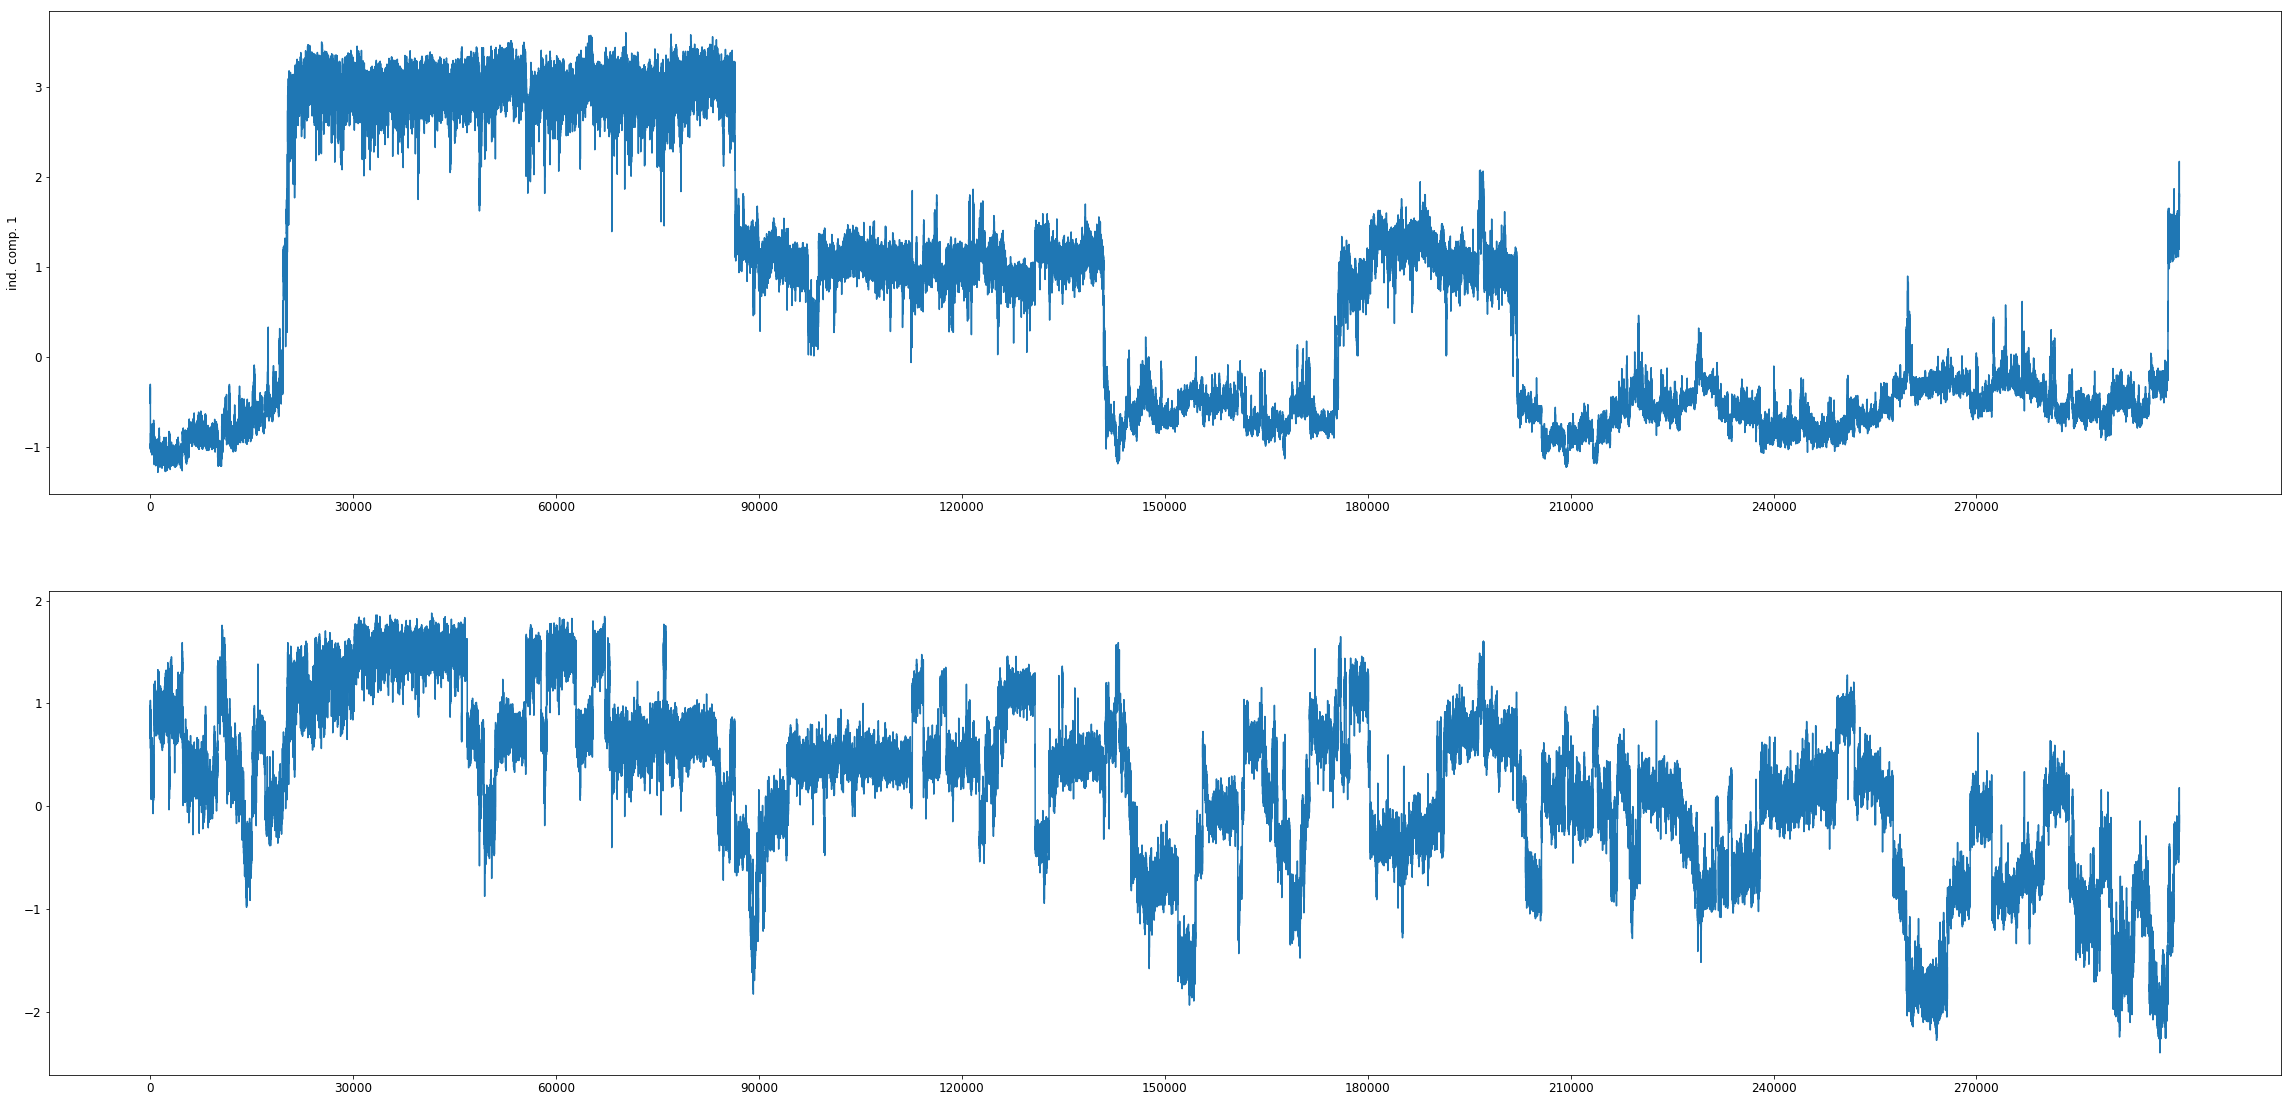

In [18]:
trajec = 9
figure(figsize=(40,105))
subplot2grid((10,1),(0,0))
plot(Y[trajec][:,0])
xticks(np.arange(0, (inp.trajectory_length(0)-1), int((inp.trajectory_length(0)-1)/10)))
ylabel('ind. comp. 1')
subplot2grid((10,1),(1,0))
plot(Y[trajec][:,1])
xticks(np.arange(0, (inp.trajectory_length(0)-1), int((inp.trajectory_length(0)-1)/10)))
save_figure('tica123plot_9.png')

Now we histogram this data and compute the apparent free energy landscape.

/home/loswald/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


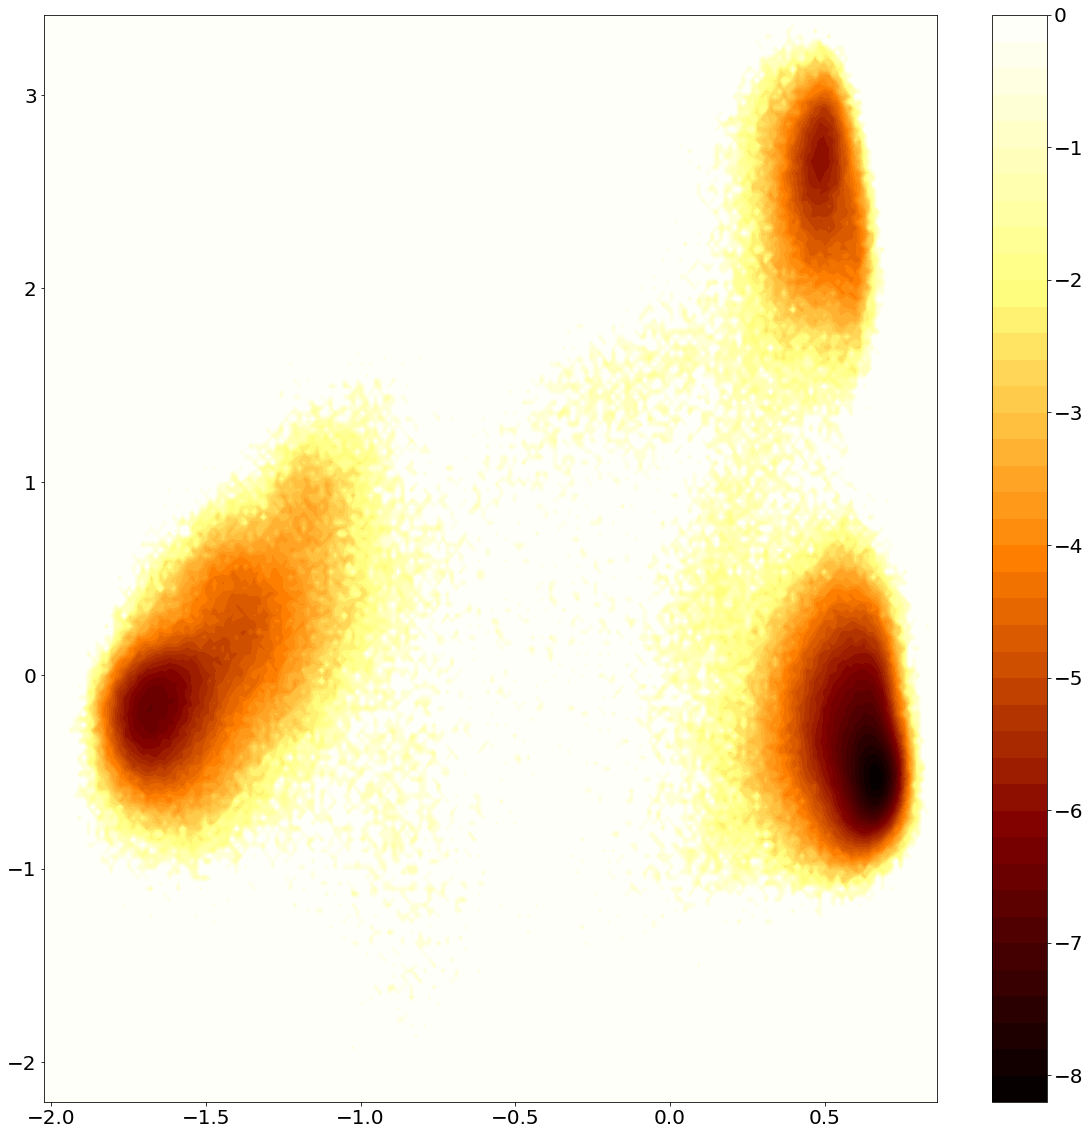

In [48]:
tica0 = np.array([])
tica1 = np.array([])
for j in range(len(Y)):
    tica0 = np.concatenate((tica0, Y[j][:,0]))

for j in range(len(Y)):
    tica1 = np.concatenate((tica1, Y[j][:,1]))
    
# histogram data
z,x,y = np.histogram2d(tica0, tica1, bins=200)
extent = (x.min(), x.max(), y.min(), y.max()) # extent of the plot
# compute free energies
F = -np.log(z)
F[F == inf] = -1000
maxval = np.amax(F)
F[F == -1000] = maxval
plt.figure(figsize=(20,20))
plt.contourf(F.T, 50, cmap=plt.cm.afmhot, extent = extent)
plt.colorbar()

plt.show()

del(tica0)
del(tica1)

So we nicely see that there are a several different energy minima are present and clearly separated in the TICA projection.

## Clustering the data

We use k-means clustering and discretize our trajectories.

**INPUT NEEDED FROM USER**: Set the number of clusters with the variable *cluster_centers*. It is critical to define microstates such that they are quite spread out in the TICA space and that there are no significant kinetic barriers within a single microstates. However, too many microstates will lead to large errors in our transition matrix estimations because of insufficient statistics. So, moderation is key. A few hundred microstates works out well in our case.

If there are problems later on with large errors or disagreements in the CK test, playing around with the number of clusters is not a bad idea.

In [32]:
cluster_centers = 250
cl = coor.cluster_kmeans(data = Y, k= cluster_centers, max_iter=100, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

07-05-18 07:19:25 pyemma.coordinates.clustering.kmeans.KmeansClustering[4] INFO     Cluster centers converged after 9 steps.


Now we plot the clusters in TICA plane.

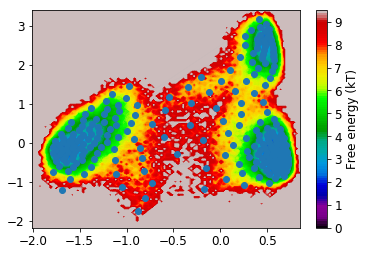

In [33]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
plot(cc_x,cc_y, linewidth = 0.01, marker='o')

For our purpose, the main result from the clustering algorithm are discrete trajectories:

In [34]:
cluster = cl.dtrajs

This is a list of integer-arrays, one for each trajectory used. 

MSM estimation
---------
In this chapter we want to estimate a Markov model, and then analyze it. First we import the msm package from pyemma, and then we also import a plotting package which offers a few standard ways for visualizing data.

In [35]:
import pyemma.msm as msm
import pyemma.plots as mplt

The quality and the practical usefulness of a Markov model depend on two main parameters:

1. The state-space discretization, i.e. which steps we have conducted before (choice of coordinates, projection method, clustering method)
2. The lag time, i.e. at which time do we count transitions.

The first choice is quite complex and there are some ways to deal with this complexity and the reduce the number of choices, although we won't discuss them in detail here. The second parameter is extremely important, and we should scan it in order to make a good selection. So let us compute the so-called implied timescales, or relaxation timescales of the Markov model at different lag times:

In [36]:
lags = [1,2,5,10,20,50,100, 150, 200, 300, 400, 500, 750, 1000, 2000]
its = msm.its(dtrajs, lags=lags)

What this function does is to estimate a Markov model at each of the given lag times $\tau$ (that are multiples of our saving step, i.e. multiples of 10 ns), compute the eigenvalues of each transition matrix, $\lambda_i(\tau)$, and then compute the relaxation timescales by:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}$$
The its object will mainly give us these estimated timescales. We can simply push the result to a standard semi-logarithmic plotting function:

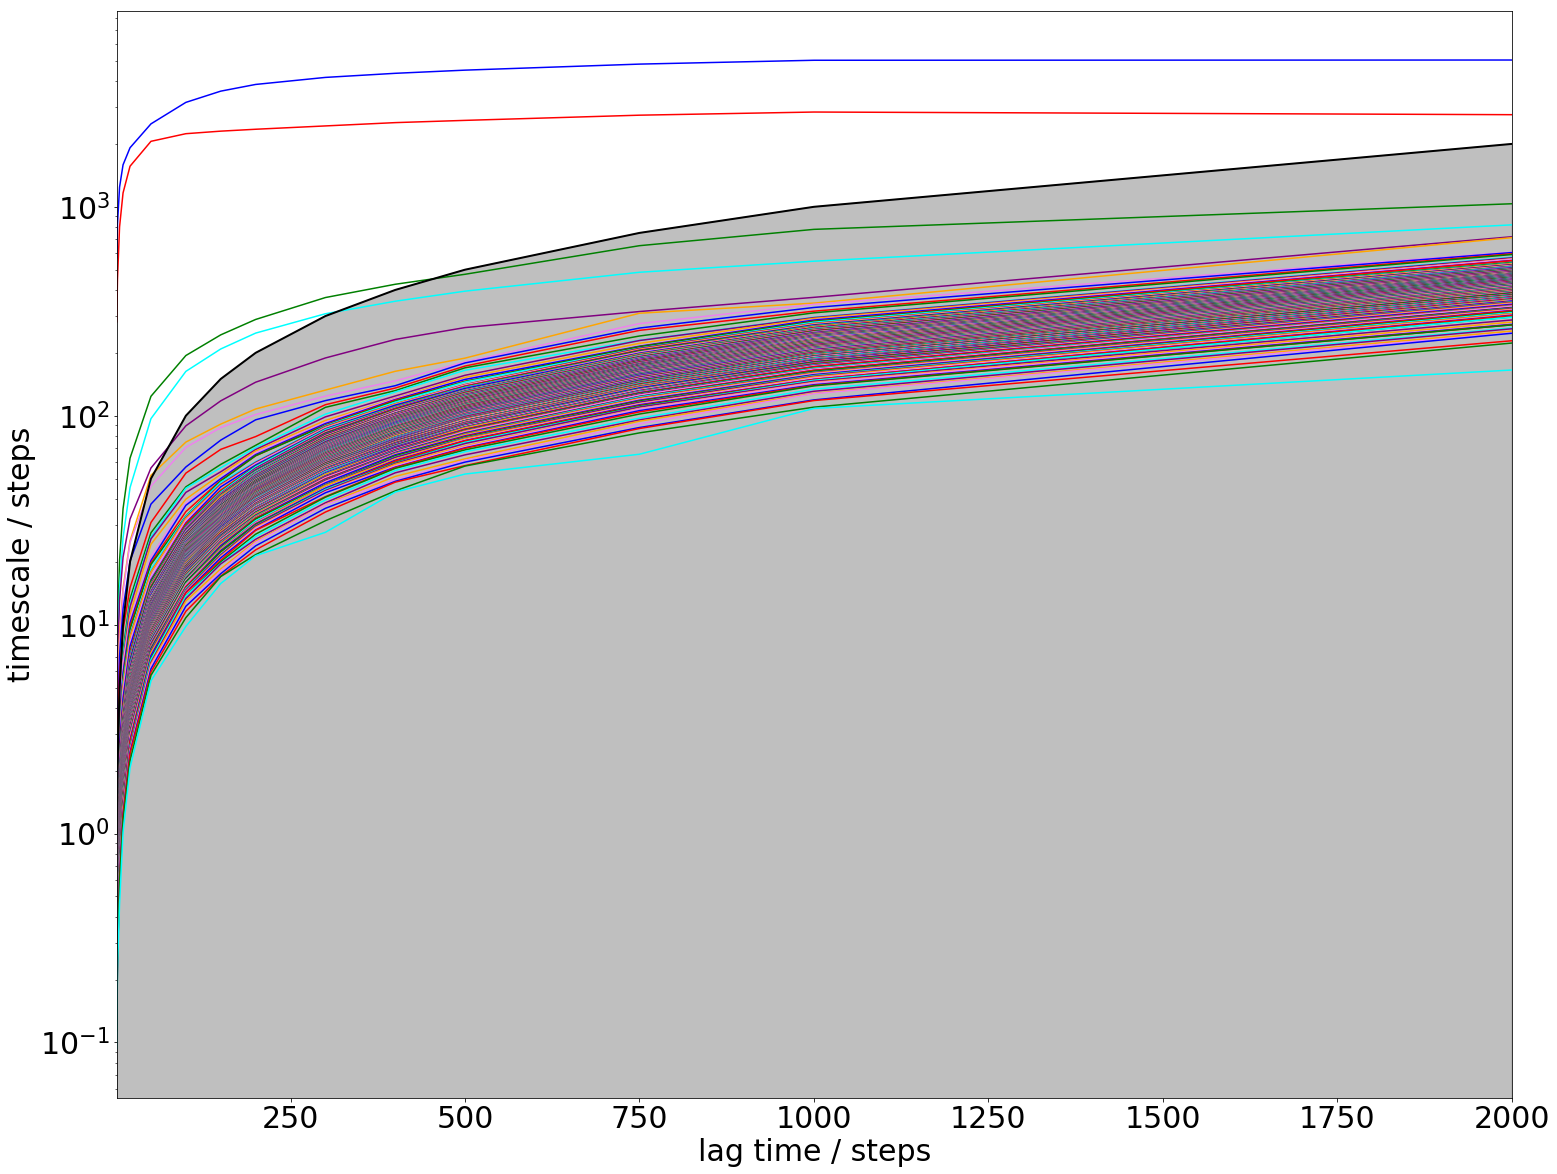

In [41]:
figure(figsize=(25,20))
matplotlib.rcParams.update({'font.size': 30})
mplt.plot_implied_timescales(its)
save_figure('timescales.png')

MSM
---
So finally we can estimate a Markov model. In fact we have already estimated a several Markov models (for different lag times above), but now we construct an msm object which will give us access to a wide variety of interesting quantities. All we need to put in are the discrete trajectories obtained from the clustering and the lag time.

**INPUT NEEDED FROM USER**:  Specify the lag time in the variable *lag*. Now, the timescales of an MSM should be independent of the lag time. For short lag times they are not, so we choose a lag time where the timescales seem converged.

(One should stay away from the grey area. The grey area is defined by lag > timescale, and in this area we cannot make a reliable estimate because the process under investigation has already decayed. Everything within or close to the grey area is distorted.)

In [39]:
lag = 250
M = msm.estimate_markov_model(dtrajs, lag)


The Markov model will be constructed on the largest connected set of states. That could mean that we exclude some states from the analysis. Let us verify that this is not the case here:

In [40]:
print ('fraction of states used = ', M.active_state_fraction)
print ('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


Spectral analysis
-----------

Let us have a closer look at the timescales that were already seen in the its plot:

(-0.5, 25.5)

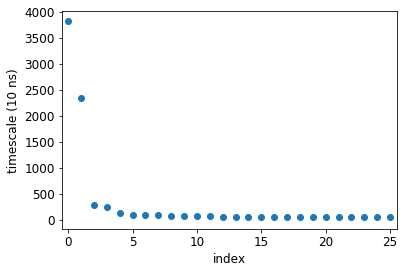

In [46]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,25.5)

We can also look at that data by taking the ratios of subsequent timescales. This shows us how big the gap of timescales (or rates) are.

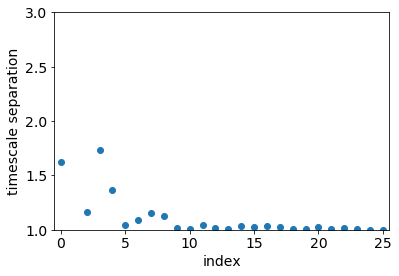

In [80]:
plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5, 25.5); ylim(1, 3);
save_figure('timescale_ratio.png')

If it can be seen that there is a large timescale separation between the *n*-th and *n+1*-th relaxation timescale: then retaining *n+1* metastable states is a good choice when coarse-graining our dynamics, 

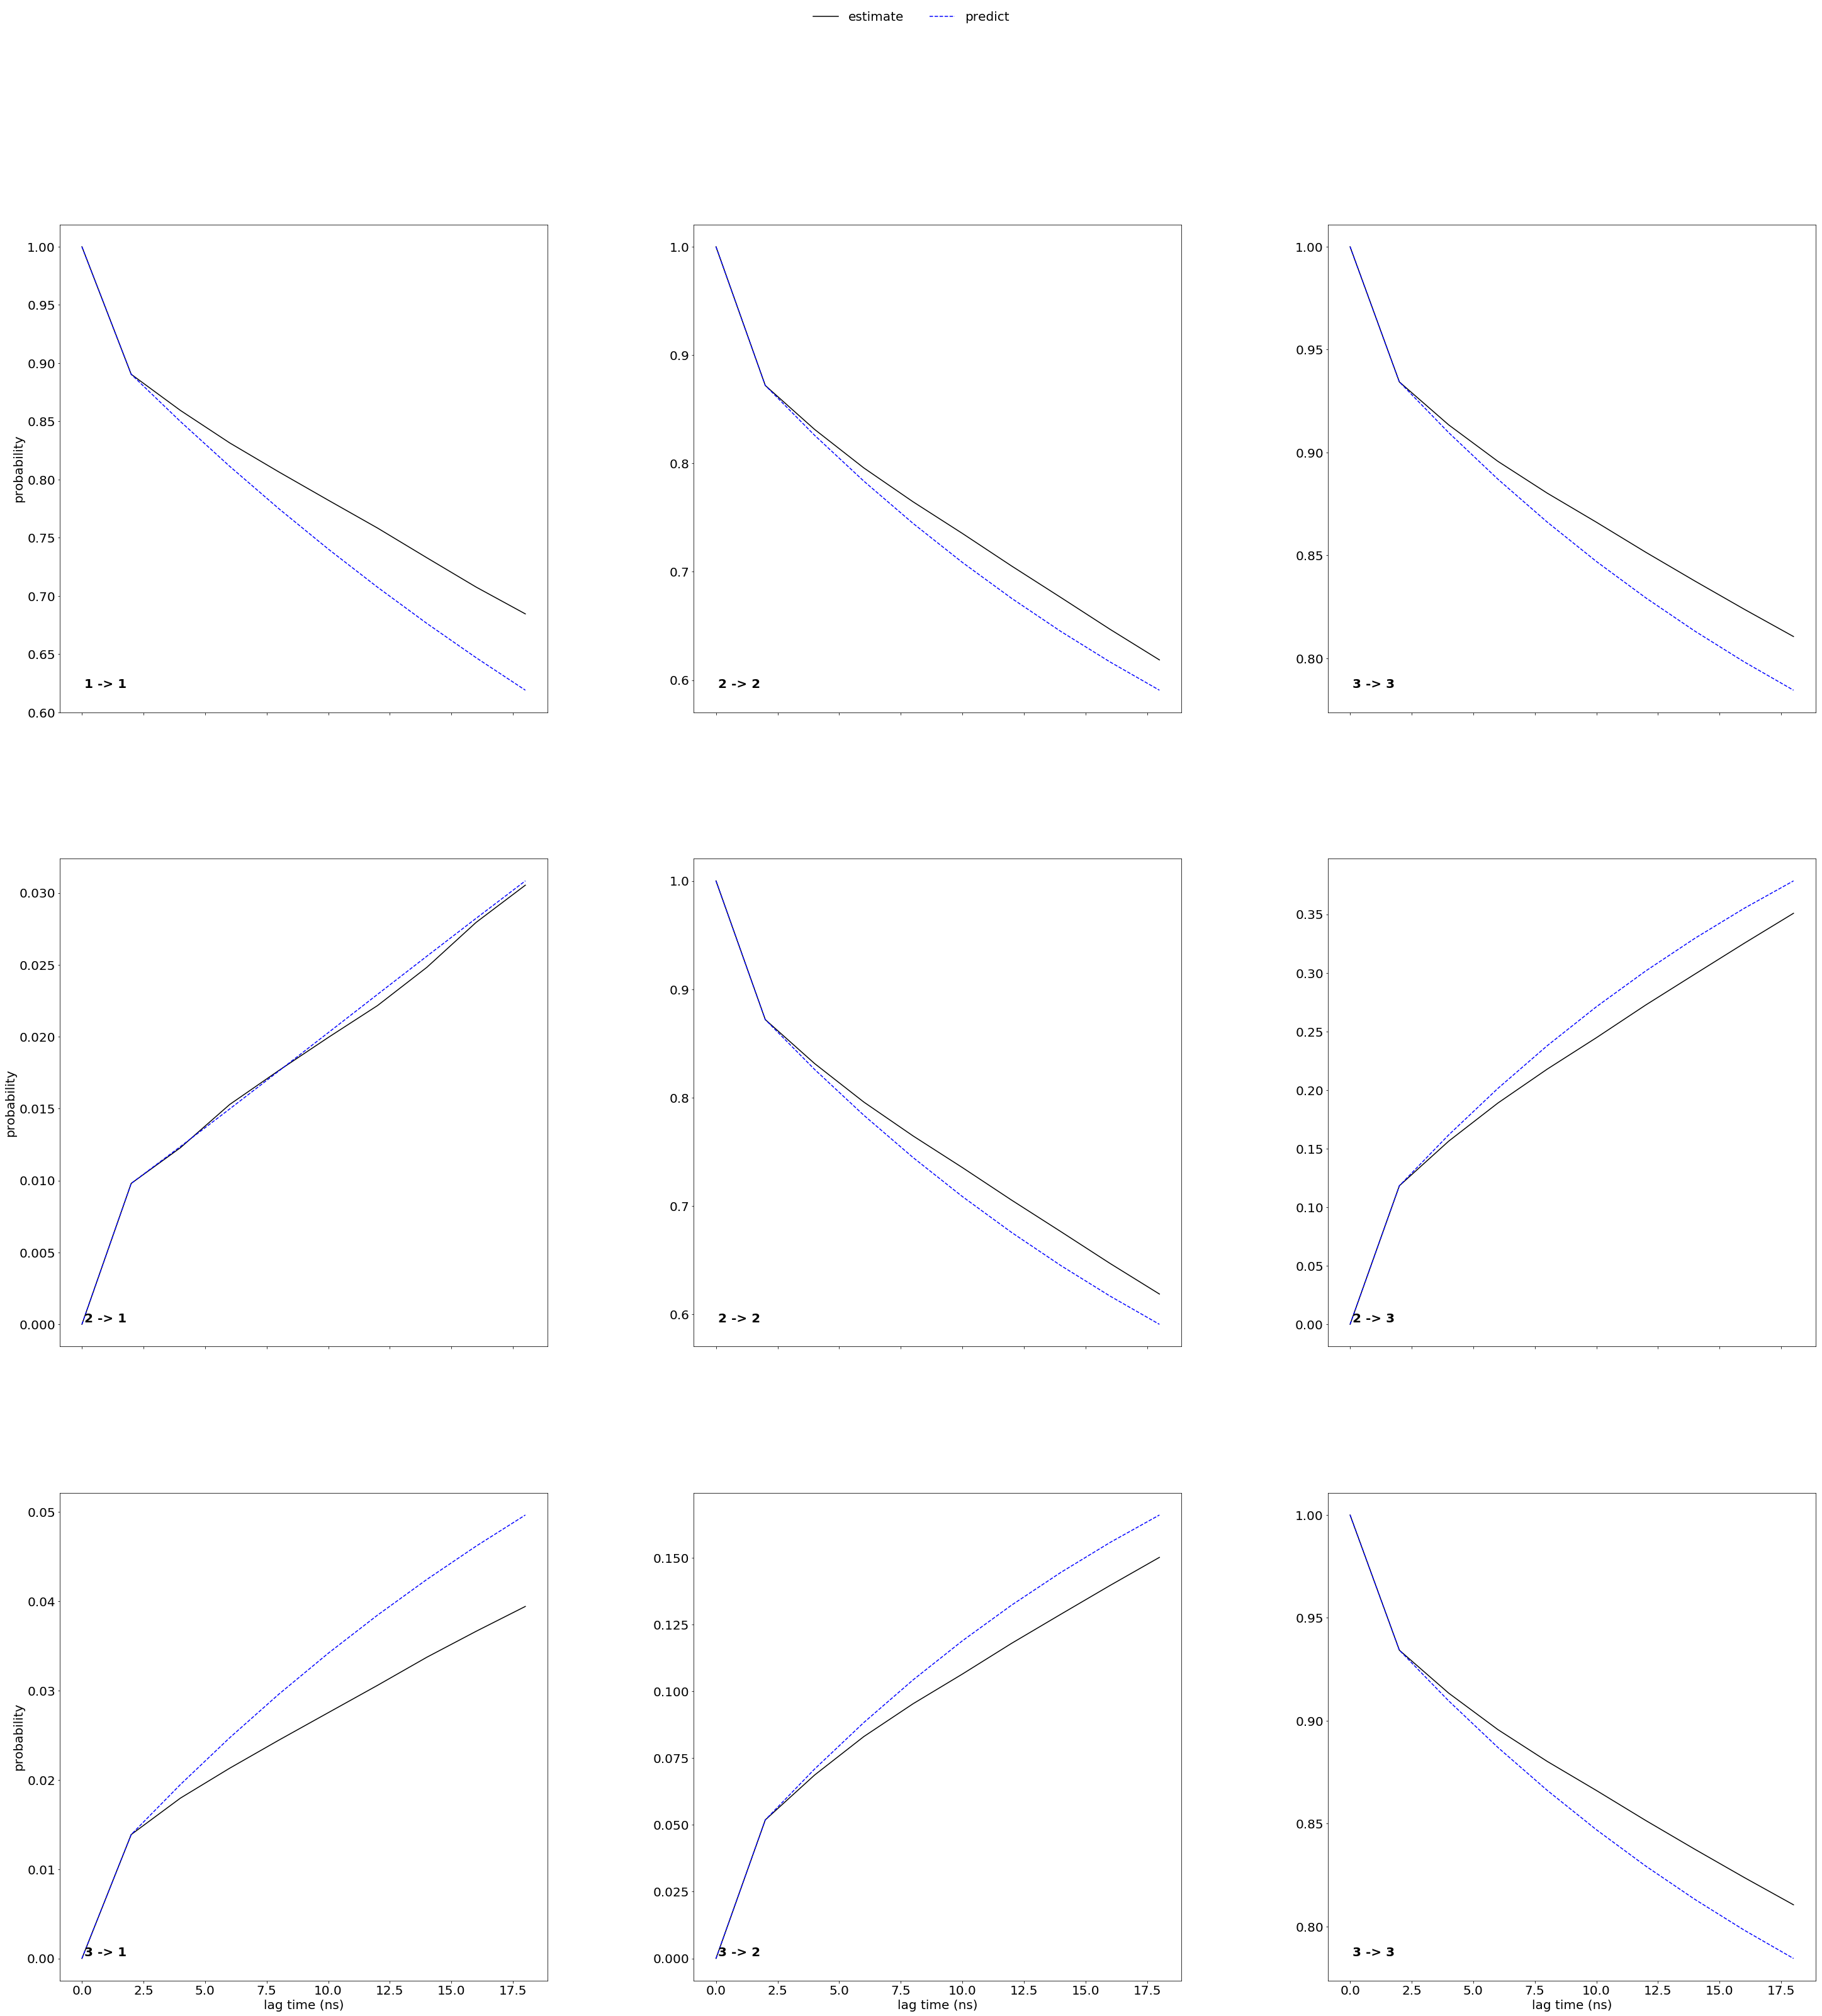

In [42]:
n_sets = 3
ck = M.cktest(n_sets, mlags=10, err_est=False, show_progress=True)

matplotlib.rcParams.update({'font.size': 20})
mplt.plot_cktest(ck, diag=True, figsize=(50,50), layout=(n_sets, n_sets), padding_top=0.1, y01=False, padding_between=0.3, dt=0.01, units='ns')
save_figure('cktest.png')

Now we want to coarse-grain our system to get a simpler description. The PCCA method uses the eigenvectors in order to perform a spectral clustering. This clustering is fuzzy, i.e. each of our k-means clusters is linked to one of the metastable states with a certain probability or membership. Here we plot the Bayesian inverse, i.e. the probability to be in a small state given that we are in a metastable state. We choose three metastable states, so we have three distributions:

In [49]:
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership = M.metastable_memberships  # get PCCA memberships

Representative Structures
--------

Now we want to see some structures. Let us use the PCCA distributions in order to select structures.
We will get 100 frame indexes for each of the three distributions

In [57]:
pcca_samples = M.sample_by_distributions(pcca_dist, 100)

and now we save them.

In [58]:
outfiles = []
for k in range(0, n_sets):
    intstring = str(k+1)
    filename = 'samples_pcca'+ intstring + '.xtc'
    outfiles.append(filename)
coor.save_trajs(inp, pcca_samples, outfiles = outfiles)

['samples_pcca1.xtc', 'samples_pcca2.xtc', 'samples_pcca3.xtc']

Now we can use nglviewer to visualize the structures we generated.

**INPUT NEEDED FROM USER**: In the *vis_set* variable, enter the index of the PCCA set you want to visualize.

In [68]:
vis_set = 2
traj_sample = mdtraj.load_xtc('samples_pcca'+ str(vis_set) + '.xtc', top=topfile, stride = 1)
w = nv.show_mdtraj(traj_sample)
w.clear_representations()
w.add_representation('tube', selection='backbone', color_scheme = 'hydrophobicity')
w

The installed widget Javascript is the wrong version.


In order to relate the structures above to the metastable states on our TICA plot, let us (ab)use PCCA to do a crisp clustering, and show the colors correspondingly. The colors for each set are randomly chosen, if you're not happy with the color scheme, re-run the cell and you will have a new scheme.

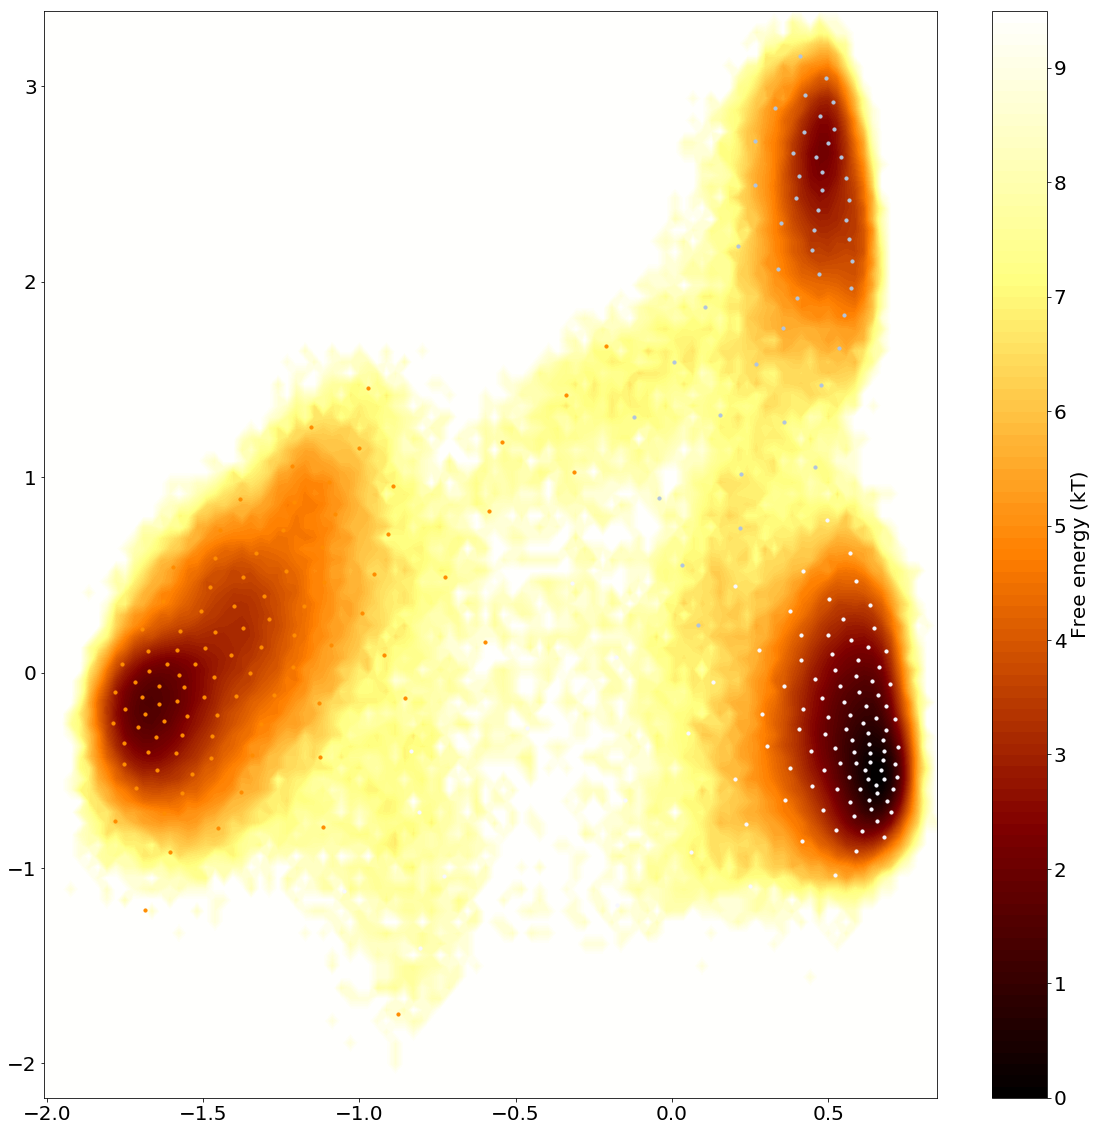

In [67]:
figure(figsize=(20,20))
pcca_sets = M.metastable_sets
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], cmap = 'afmhot');
colornames = list(mpltlib.colors.cnames.keys())
colorselect = rndm.sample(colornames, n_sets + 1)
for k in range(n_sets):
    scatter(cl.clustercenters[pcca_sets[k],0], cl.clustercenters[pcca_sets[k],1], color=colorselect[k], s=10)

save_figure('freeenergydiagram.png')
# STATE 1 TIGHT U
# STATE 2 LOOSE U
# STATE 3 BETA STRAND

One can plot average intermolecular distance-inverses over TICA space to get an idea of what is going on even before using visualization software. (Red indicates higher oligomerization states, deeper shades of blue indicate a region where the system is more dissociated.)

In [103]:
traj_dimer = []
tica0target = 0.15
tica1target = -2.5
for m in range(len(Y)):
    traj_comp = mdtraj.load_xtc(traj_list[m], top='protein.gro', stride = 1)
    tica0 = Y[m][:,0]
    tica1 = Y[m][:,1]
    for n in range(len(tica0)):
        if (((tica0[n] - tica0target)**2 + (tica1[n] - tica1target)**2) < 0.05**2):
            traj_dimer.append(traj_comp[n])
traj_sample = mdtraj.join(traj_dimer, check_topology=False, discard_overlapping_frames=False)
print(traj_sample)
traj_sample.save('oligomer.xtc')

<mdtraj.Trajectory with 43 frames, 205 atoms, 20 residues, and unitcells>


Hidden Markov Model
---------------------
Finally, having coarse-grained our markov state model, we can generate a hidden markov model.

In [49]:
hmm = M.coarse_grain(n_sets)

In [50]:
np.set_printoptions(precision=12, suppress=True)
hmm.stationary_distribution

array([ 0.106687081329,  0.276353230422,  0.616959688249])

In [51]:
np.set_printoptions(precision=4, suppress=True)
print(hmm.transition_matrix)

[[ 0.9653  0.0048  0.0299]
 [ 0.0019  0.9506  0.0475]
 [ 0.0052  0.0213  0.9736]]


In [52]:
pcca_sets = M.metastable_sets
xavg = avg_by_set(cc_x, pcca_sets)
yavg = avg_by_set(cc_y, pcca_sets)
avgpos = np.zeros((n_sets,2))
avgpos[:,0] = xavg
avgpos[:,1] = yavg
print(avgpos)

[[ 0.3746  2.0885]
 [-1.3491  0.1089]
 [ 0.4334 -0.3231]]


Visualize the transition matrix as a network diagram. 

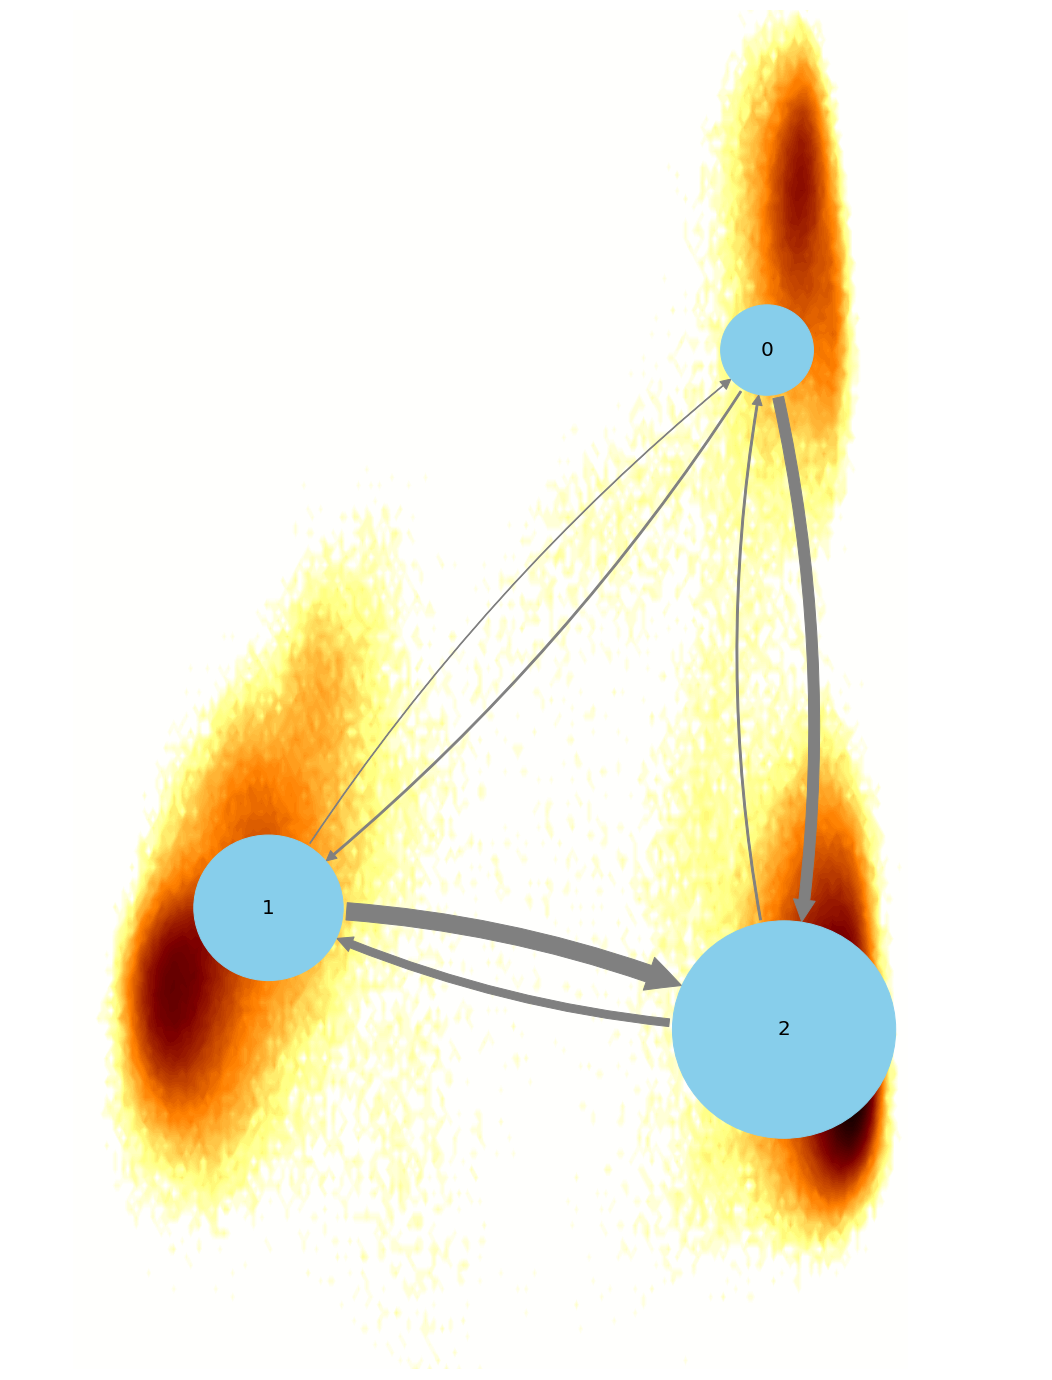

In [63]:
#cf=contourf(F.T, 100, cmap=plt.cm.afmhot, extent = extent, zorder = 0)
fig,_ = mplt.plot_markov_model(hmm, pos=avgpos, minflux=1e-4, arrow_scale=1.5, arrow_label_format=' ', state_colors='skyblue', figpadding=0.5, max_width =30, max_height = 25)
cf = cf=contourf(F.T, 100, cmap=plt.cm.afmhot, extent = extent, zorder = 0)
gca().set_frame_on(False)